# Obligatorio 2 - Big Data Science

Integrantes del grupo: Martín Brian - Joaquín Martínez

Debajo de cada pregunta o tarea incluya las celdas necesarias para desarrolar la respuesta. Puede usar una o varias celdas de código o mark down (https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook)

Para entregar, renombrar este notebook como "Obligatorio 2 - Apellido1 - Apellido 2 - Apellido 3" con los apellidos de los miembros del grupo. Un solo integrante del grupo debe realizar la entrega. 


1. Cargar los datos del Obligatorio 1, de entrenamiento (.data) y validación (.test) en spark dataframes (distintos). Los nombres de las columnas deben corresponder a los especificados en "Attribute Information".

In [1]:
#from pyspark import SparkContext
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext.getOrCreate()

spark = SQLContext(sc)

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("workclass", StringType(), True),
    StructField("fnlwgt", FloatType(), True),
    StructField("education", StringType(), True),
    StructField("education-num", FloatType(), True),
    StructField("marital-status", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("relationship", StringType(), True),
    StructField("race", StringType(), True),
    StructField("sex", StringType(), True),
    StructField("capital-gain", FloatType(), True),
    StructField("capital-loss", FloatType(), True),
    StructField("hours-per-week", FloatType(), True),
    StructField("native-country", StringType(), True),
    StructField("salary", StringType(), False)
])

In [3]:
#Leemos los archivos
df_data = spark.read.csv("./adult.data", header=False,schema=schema)
df_test = spark.read.csv("./adult.test", header=True,schema=schema)

In [4]:
df_data.toPandas()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302.0,Assoc-acdm,12.0,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38.0,United-States,<=50K
32557,40,Private,154374.0,HS-grad,9.0,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
32558,58,Private,151910.0,HS-grad,9.0,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
32559,22,Private,201490.0,HS-grad,9.0,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


In [5]:
df_data.toPandas().describe(include = 'all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648804,87.303833,40.437454,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.291992,402.960205,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [6]:
from pyspark.sql.functions import regexp_replace

# Limpiamos puntos en la columna salario
df_test = df_test.withColumn('salary', regexp_replace('salary', '<=50K.', '<=50K'))
df_test = df_test.withColumn('salary', regexp_replace('salary', '>50K.', '>50K'))

2. Seleccionar un conjunto relevante de 5 atributos y crear un Spark Pipeline en el que el estimator sea un DecisionTreeClassifier (https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier). Puede utilizar libremente los transformers/estimators de Spark para realizar ingeniería de atributos (StringIndexer, OneHotEncoding, etc).

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, Bucketizer, OneHotEncoder

def get_indexed_name(name):
    return f"{name}_index"

def get_onehot_name(name):
    return f"{name}_onehot"

chosen_columns = ["age", "sex", "education-num", "occupation", "education"]

string_type_name = StringType.typeName()
chosen_columns_dtypes = df_data.select(chosen_columns).dtypes
strings_to_index = list(filter(lambda column: dict(chosen_columns_dtypes)[column] == string_type_name, chosen_columns))
string_indexers = [StringIndexer(inputCol=column, outputCol=get_indexed_name(column)) for column in strings_to_index]

encoder_output=[get_onehot_name(string) for string in strings_to_index]

encoder = OneHotEncoder(inputCols=[get_indexed_name(string) for string in strings_to_index],
                        outputCols=encoder_output)

splits = [0, 25, 40, 60, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="age", outputCol="age_bucketed")

chosen_numeric=set(chosen_columns)-set(strings_to_index)

chosen = list(chosen_numeric)
chosen.extend(encoder_output)
chosen.append("age_bucketed")

assembler = VectorAssembler(inputCols=chosen, outputCol="vector_col") 
salary_indexer = StringIndexer(inputCol="salary", outputCol="salary_indexed")

# Decision tree parameters (para poder ajustarlo)
"""DecisionTreeClassifier(*, featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', seed=None, weightCol=None, leafCol='', minWeightFractionPerNode=0.0)"""

dt = DecisionTreeClassifier(labelCol="salary_indexed", featuresCol="vector_col", maxDepth=8)

stages = string_indexers
stages.extend([salary_indexer, encoder, bucketizer, assembler, dt])
pipeline = Pipeline(stages=stages)


3. Hacer el fit del pipeline con los datos de entrenamiento. 


In [8]:
model = pipeline.fit(df_data)

predictions_in_training = model.transform(df_data)
predictions = model.transform(df_test)

predictions.select("prediction", "salary_indexed", "vector_col").show(15)

def get_confusion_matrix(predictions):
    confusion=predictions.groupBy("prediction", 'salary_indexed').count()
    confusion_collected = confusion.collect()
    hits = 0
    total = 0
    for row in confusion_collected:
        total += row[2]
        if row[0]==row[1]:
            hits += row[2]

    print(f"hits/total: {hits/total}")
    return confusion.toPandas()

print(get_confusion_matrix(predictions_in_training), end='\n'*4)
print(get_confusion_matrix(predictions))

+----------+--------------+--------------------+
|prediction|salary_indexed|          vector_col|
+----------+--------------+--------------------+
|       0.0|           0.0|(33,[0,1,2,9,22,3...|
|       0.0|           0.0|(33,[0,1,2,13,17,...|
|       0.0|           1.0|(33,[0,1,2,15,23,...|
|       0.0|           1.0|(33,[0,1,2,9,18,3...|
|       0.0|           0.0|(33,[0,1,10,18],[...|
|       0.0|           0.0|(33,[0,1,2,8,24,3...|
|       0.0|           0.0|(33,[0,1,2,10,17,...|
|       1.0|           1.0|(33,[0,1,2,3,26,3...|
|       0.0|           0.0|(33,[0,1,8,18],[1...|
|       0.0|           0.0|(33,[0,1,2,4,25,3...|
|       0.0|           1.0|(33,[0,1,2,9,17,3...|
|       0.0|           0.0|(33,[0,1,2,6,19,3...|
|       0.0|           0.0|(33,[0,1,6,17,32]...|
|       0.0|           0.0|(33,[0,1,2,10,17,...|
|       0.0|           1.0|(33,[0,1,2,9,17,3...|
+----------+--------------+--------------------+
only showing top 15 rows

hits/total: 0.8143484536715703
   predictio

4. Graficar la curva ROC utilizando los datos de validación (sin usar el paquete de evluación de Spark pyspark.ml.evaluation)

DataFrame[prediction: double, salary_indexed: double, vector_col: vector, probability: vector]

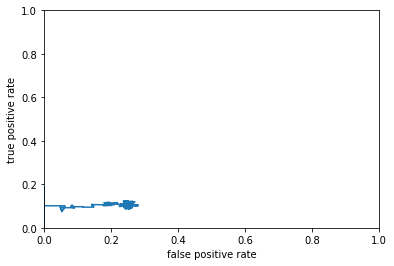

In [12]:
true_positive = 0
false_positive = 0
true_negative = 0
false_negative = 0
roc_points_false_positive_rate = []
roc_points_true_positive_rate = []

threshold = [x / 100 for x in range(0, 101, 5)]

predictions.select("prediction", "salary_indexed", "probability").collect()

for value in threshold:
    


    if row.prediction == 1.0 and row.salary_indexed == 1.0:
        true_positive += 1
    elif row.prediction == 1.0:
        false_positive += 1
    elif row.prediction == 0.0 and row.salary_indexed == 1.0:
        true_negative += 1
    else:
        false_negative += 1
    
    try:
        true_positive_rate = true_positive/(true_positive+false_negative)
    except ZeroDivisionError:
        true_positive_rate = 0
    try:
        false_positive_rate = false_positive/(false_positive+true_negative)
    except ZeroDivisionError:
        false_positive_rate = 0

    roc_points_true_positive_rate.append(true_positive_rate)
    roc_points_false_positive_rate.append(false_positive_rate)
    

# import matplotlib.pyplot as plt
# plt.plot(roc_points_false_positive_rate, roc_points_true_positive_rate)

# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')

# plt.axis([0, 1, 0, 1])
# plt.show()

predictions.select("prediction", "salary_indexed", "vector_col", "probability").toPan

5. Escribir dos funciones train() y predict() que creen el arbol de acuerdo a la metodología vista en clase (utilizando entropía como métrica de homogeneidad de clases).
```
def train(train_dataframe):
    '''
    @return devuelve una estructura de datos que representa el árbol de decision
    '''
     pass        
```

```
def predict(tree, train_dataframe)
    '''
    @param tree la estructura de datos que representa el árbol de decisión.
    @ return un dataframe con todos los datos de train_dataframe con una columna adicional que representa la probabilidad de que el income sea >50K. 
    '''
    pass
```    
Ejemplo de uso:

```
tree = train(train_dataframe)
predictions_df = predict(tree, train_dataframe)
```

In [10]:
# 

<i>[Extra credit y alumnos masters]</i>
    
5.  Mejorar la implementación de su algoritmo evitando hacer el split cuando no se logra un mínimo de Information Gain ( https://en.wikipedia.org/wiki/Information_gain_in_decision_trees   )


In [11]:
#